In [1]:
import json
from datetime import datetime
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import pickle
import teams

In [8]:

error_list = []
def get_predict_data(predict_team_dict, opposing_team_dict):

    predict_players_mmr_total = 0
    predict_players_mmr_count = 0
    opposing_players_mmr_total = 0
    opposing_players_mmr_count = 0

    for x, i in enumerate(predict_team_dict['predict_players']):

        try:
            predict_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            predict_players_mmr_count += 1

        except:

            error_list.append()
            
    # get the average MMR of the predict team
    predict_players_mmr_average = predict_players_mmr_total / predict_players_mmr_count

    predict_team_total_matches = predict_team_dict['predict_team_stat'][0]['predict_team_wins_total'] + predict_team_dict['predict_team_stat'][0]['predict_team_losses_total']
    
    predict_team_win_pct = round(predict_team_dict['predict_team_stat'][0]['predict_team_wins_total'] / predict_team_total_matches * 100, 2)
    
    for y, j in enumerate(opposing_team_dict['predict_players']):

        try:
            opposing_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            opposing_players_mmr_count += 1

        except:

            error_list.append()
    
    # get the average MMR of the opposing team
    opposing_players_mmr_average = opposing_players_mmr_total / opposing_players_mmr_count

    opposing_team_total_matches = opposing_team_dict['predict_team_stat'][0]['predict_team_wins_total'] + opposing_team_dict['predict_team_stat'][0]['predict_team_losses_total']

    opposing_team_win_pct = round(opposing_team_dict['predict_team_stat'][0]['predict_team_wins_total'] / opposing_team_total_matches * 100, 2)

    predict_data_df =  pd.DataFrame(data = {'predict_team_total_matches' : predict_team_total_matches, 
                                            'predict_team_win_pct' : predict_team_win_pct, 
                                            'predict_team_rating' : predict_team_dict['predict_team_stat'][0]['predict_team_rating'], 
                                            'predict_players_mmr_average' : predict_players_mmr_average, 
                                            'opposing_team_total_matches' : opposing_team_total_matches, 
                                            'opposing_team_win_pct' : opposing_team_win_pct, 
                                            'opposing_team_rating' : opposing_team_dict['predict_team_stat'][0]['predict_team_rating'], 
                                            'opposing_players_mmr_average' : opposing_players_mmr_average}, 
                                            index = [0])     

    return predict_data_df           

In [58]:
tundra_esports_profile_df = get_predict_data(tundra_esports_matches_json[0], team_secret_matches_json[0])

In [21]:
tundra_esports_matches_df = team_matches_df(tundra_esports_matches_json, 'tundra_esports', 8291895)

In [22]:
tundra_esports_matches_df.shape

(264, 23)

In [23]:
tundra_esports_matches_df.head()

,start_date,predict_team_name,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_name,opposing_team_id,opposing_team_total_matches,...,league_name,leagueid,cluster,radiant_win,radiant,duration,match_id,match_outcome,predict_team_score,opposing_team_score
0,2022-10-23 00:17:21,tundra_esports,8291895,261,62.84,1565.76,7692.6,Team Aster,6209166,927,...,The International 2022,14268,154,False,False,2407,6817434540,True,23,13
1,2022-10-22 22:58:55,tundra_esports,8291895,261,62.84,1565.76,7692.6,Team Aster,6209166,927,...,The International 2022,14268,154,True,True,2973,6817320059,True,30,20
2,2022-10-21 14:05:39,tundra_esports,8291895,261,62.84,1565.76,7692.6,OG,2586976,1350,...,The International 2022,14268,154,False,False,2316,6815171709,True,34,23
3,2022-10-21 13:06:31,tundra_esports,8291895,261,62.84,1565.76,7692.6,OG,2586976,1350,...,The International 2022,14268,154,True,True,1449,6815136578,True,26,7
4,2022-10-18 18:17:15,tundra_esports,8291895,261,62.84,1565.76,7692.6,Entity,8605863,208,...,The International 2022,14268,154,True,True,2455,6811014822,True,27,26


In [17]:
og = teams.Team('og_data.json')

In [18]:
og_matches_df = og.open_file()

In [19]:
og_matches_df.shape

(1360, 23)

In [6]:
tundra_esports_matches_df.describe()

,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_id,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average,leagueid,cluster,duration,match_id,predict_team_score,opposing_team_score
count,264.0,264.0,2.640000e+02,2.640000e+02,264.000000,2.640000e+02,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,2.640000e+02,264.000000,264.000000
mean,8291895.0,261.0,6.284000e+01,1.565760e+03,7670.090909,4.978329e+06,984.731061,57.815909,1370.443568,6728.879545,13772.102273,237.659091,2232.227273,6.363054e+09,25.878788,22.246212
std,0.0,0.0,2.135677e-14,4.556111e-13,66.745997,3.438359e+06,759.089268,7.572022,145.844306,464.945297,491.619224,54.800201,520.863127,2.844733e+08,11.748978,11.440206
min,8291895.0,261.0,6.284000e+01,1.565760e+03,7144.600000,1.500000e+01,4.000000,10.000000,927.633000,4665.600000,12720.000000,121.000000,1030.000000,5.815365e+09,0.000000,0.000000
25%,8291895.0,261.0,6.284000e+01,1.565760e+03,7679.200000,1.838315e+06,283.000000,55.230000,1290.790000,6404.800000,13379.000000,182.000000,1878.750000,6.121865e+09,16.000000,12.750000
50%,8291895.0,261.0,6.284000e+01,1.565760e+03,7679.200000,7.119388e+06,610.000000,59.290000,1420.200000,6787.800000,13804.000000,273.000000,2210.500000,6.389645e+09,26.000000,21.000000
75%,8291895.0,261.0,6.284000e+01,1.565760e+03,7692.600000,8.254400e+06,1545.000000,61.410000,1453.670000,7047.750000,14192.000000,274.000000,2591.250000,6.577042e+09,34.000000,31.000000
max,8291895.0,261.0,6.284000e+01,1.565760e+03,7692.600000,8.740926e+06,2517.000000,66.670000,1576.710000,7700.200000,14417.000000,274.000000,3864.000000,6.817435e+09,58.000000,53.000000


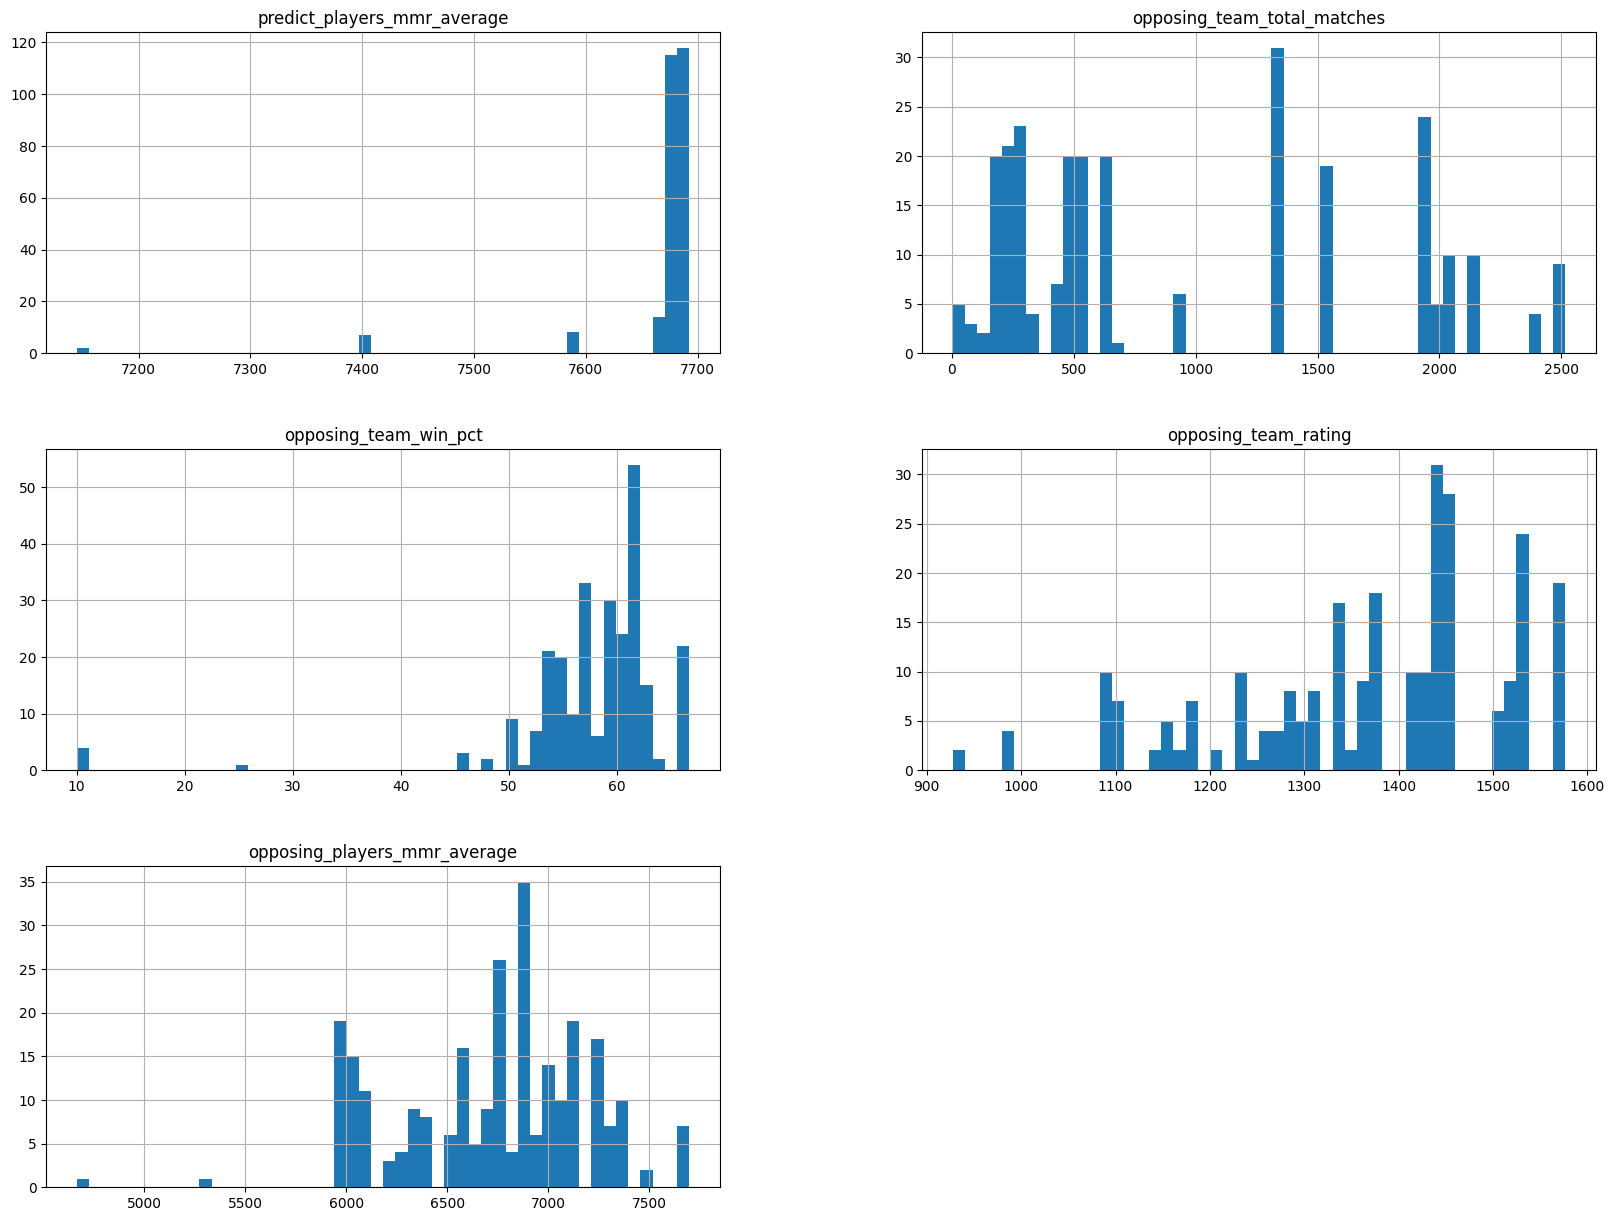

In [7]:
tundra_esports_matches_df.loc[:,['predict_players_mmr_average', 
                   'opposing_team_total_matches', 
                   'opposing_team_win_pct', 
                   'opposing_team_rating', 
                   'opposing_players_mmr_average']].hist(bins = 50, figsize=(20, 15))
plt.show()

In [20]:
X = og_matches_df.drop(labels = ['match_outcome', 
                                    'start_date', 
                                    'predict_team_score',
                                    'opposing_team_score',
                                    'predict_team_name',
                                    'predict_team_id',
                                    'opposing_team_name',
                                    'opposing_team_id',
                                    'league_name',
                                    'leagueid',
                                    'cluster', 
                                    'radiant_win', 
                                    'radiant', 
                                    'match_id', 
                                    'duration'], axis = 1)

y = og_matches_df.match_outcome

# Consider scaling the data (Normalisation or Standardisation)

In [21]:
X.head()

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
0,1350,61.41,1439.16,5962.2,1949,59.26,1532.73,7219.6
1,1350,61.41,1439.16,5962.2,1949,59.26,1532.73,7219.6
2,1350,61.41,1439.16,5962.2,171,56.73,1357.28,6785.2
3,1350,61.41,1439.16,5962.2,171,56.73,1357.28,6785.2
4,1350,61.41,1439.16,5962.2,171,56.73,1357.28,6785.2


In [22]:
X.columns

Index(['predict_team_total_matches', 'predict_team_win_pct',
       'predict_team_rating', 'predict_players_mmr_average',
       'opposing_team_total_matches', 'opposing_team_win_pct',
       'opposing_team_rating', 'opposing_players_mmr_average'],
      dtype='object')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [25]:
y_pred = log_reg.predict(X_test)

In [26]:
y_pred[0:10]

array([ True, False,  True, False,  True,  True,  True,  True,  True,
       False])

In [27]:
y_test[0:10]

51      False
1101     True
1313     True
514      True
1075     True
430      True
855      True
764     False
985      True
712     False
Name: match_outcome, dtype: bool

In [28]:
conf_mtx = confusion_matrix(y_test, y_pred)

In [29]:
conf_mtx

array([[ 48,  49],
       [ 46, 129]], dtype=int64)

# Explanation

[[True Negative, False Positive],

 [False Negative, True Positive]]
 
In the first row, the model CORRECTLY predicted 40 losses, but INCORRECTLY predicted 54 wins (it should have been losses)

In the second row, the model INCORRECTLY predicted 28 losses (it should have been wins), while it CORRECTLY predicted 145 wins
 


In [30]:
precision_score(y_test, y_pred)

0.7247191011235955

The Logistic Regression model can CORRECTLY predict WINS 71.77% of the time

In [31]:
recall_score(y_test, y_pred)

0.7371428571428571

Save the Logistic Regression as a Pickle File

In [136]:
pickle.dump(log_reg, open('royal_never_give_up_log_reg.pkl', 'wb'))

In [30]:
X_test[0:5]

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
115,239,55.23,1447.04,6557.6,1157,54.02,1198.46,6161.8
15,239,55.23,1447.04,6557.6,927,55.02,1504.82,7289.6
211,239,55.23,1447.04,6557.6,1157,54.02,1198.46,6179.2
126,239,55.23,1447.04,6557.6,277,59.21,1420.20,6464.2
6,239,55.23,1447.04,6557.6,277,59.21,1420.20,6559.8


In [31]:
y_test[0:5]

497    False
244    False
552    False
213     True
549    False
Name: match_outcome, dtype: bool

In [32]:
y_pred[0:5]

array([ True,  True,  True,  True, False])

In [33]:
X_test.iloc[1, :]

predict_team_total_matches       629.00
predict_team_win_pct              60.73
predict_team_rating             1375.73
predict_players_mmr_average     6797.20
opposing_team_total_matches      370.00
opposing_team_win_pct             57.03
opposing_team_rating            1279.66
opposing_players_mmr_average    7056.40
Name: 244, dtype: float64

In [ ]:
test_list = []
for item in X_test.iloc[1, :]:
    test_list.append(item)

In [ ]:
log_reg.predict([test_list])

c:\Users\johnp\deploy-mlmodel\deploy-mlmodel-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])